In [1]:
import math 

import numpy as np
import pandas as pd

import sklearn
print('The scikit-learn version is {}.'.format(sklearn.__version__))

from sklearn.feature_extraction.text import TfidfTransformer

The scikit-learn version is 0.23.1.


In [2]:
df_data_train = pd.read_csv('./Amazon_Review_Data/amazon_review_ID.shuf.lrn.csv', low_memory=False, sep=',')
df_data_test = pd.read_csv('./Amazon_Review_Data/amazon_review_ID.shuf.tes.csv', low_memory=False, sep=',')

In [3]:
df_data_train.head()

,ID,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V9992,V9993,V9994,V9995,V9996,V9997,V9998,V9999,V10000,Class
0,0,8,6,10,6,7,2,2,2,3,...,1,0,0,0,0,0,0,0,0,Chell
1,1,13,1,13,9,8,8,2,3,2,...,4,1,2,1,0,1,0,0,0,Engineer
2,2,16,7,6,7,9,3,4,2,6,...,0,0,0,0,1,0,0,0,0,Grove
3,3,8,11,10,11,3,7,0,4,2,...,0,0,1,0,0,0,2,1,0,Davisson
4,4,10,11,8,5,3,4,2,5,5,...,0,0,0,0,0,0,0,0,0,Wilson


## Class Distribution

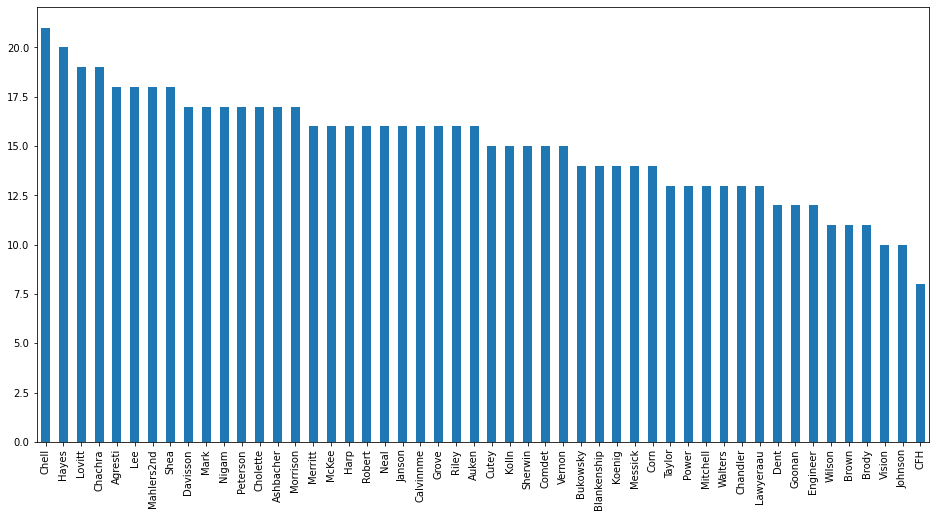

In [4]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(16,8))
df_data_train['Class'].value_counts().plot(kind='bar')
plt.show()

## Dataframe Pre-Processing

In [5]:
df_train = df_data_train.copy()

class_factor = df_data_train['Class'].factorize()
class_index = class_factor[1]

df_train['ClassF'] = class_factor[0]

columns = sorted(set(df_data_train.columns) - set(['ID', 'Class', 'ClassF']))

X = df_train[columns].to_numpy()
y = df_train['ClassF'].to_numpy()


X_test = df_data_test[columns]

## TDIF Transformation

In [6]:
tfidf = TfidfTransformer()
X_tfidf = tfidf.fit_transform(X)
X_test_tfidf = tfidf.transform(X_test)

print(X_tfidf.shape)

unique_classes = np.unique(y)
print(len(unique_classes))

(750, 10000)
50


In [21]:
np.eye(len(unique_classes), dtype='uint8')[y]

array([[1, 0, 0, ..., 0, 0, 0],
       [0, 1, 0, ..., 0, 0, 0],
       [0, 0, 1, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 1, 0]], dtype=uint8)

## PyTorch

### CV Model

In [36]:
import torch 
import torch.nn as nn
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report, make_scorer, accuracy_score, balanced_accuracy_score, f1_score

def create_model():
    num_inputs = 10000
    num_outputs = 50
    return nn.Sequential(
        nn.Linear(num_inputs, 1000),
        nn.ReLU(),
        nn.Linear(1000, num_outputs),
        nn.Sigmoid()
    )

def nn_fit_and_predict(X_cv_train, y_cv_train, X_cv_test, y_cv_test):
    nX = torch.from_numpy(X_cv_train.todense()).float()
    nX_test = torch.from_numpy(X_cv_test.todense()).float()
    ny = torch.from_numpy(y_cv_train)
    ny_test = torch.from_numpy(y_cv_test)

    # Train network
    model = create_model()

    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr = 0.01)

    for epoch in range(20):
        y_pred = model(nX)

        loss = criterion(y_pred, ny)

        y_pred_a = torch.argmax(y_pred, dim=1).detach().numpy()
        accuracy = accuracy_score(y_pred_a, ny)
        
        y_pred_test = model(nX_test)
        y_pred_a_test = torch.argmax(y_pred_test, dim=1).detach().numpy()
        accuracy_test = accuracy_score(y_pred_a_test, ny_test)

        print('epoch: ', epoch,' loss: ', loss.item(),' accuracy(train): ', accuracy,' accuracy(test): ', accuracy_test)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        

    # Finally predict test
    y_output = model(nX_test)
    y_prediction = torch.argmax(y_output, dim=1).detach().numpy()
    return y_prediction


cv_results_accuracy = []
cv_results_balanced_accuracy = []
cv_results_f1_weighted = []
    
cv_fold = KFold(n_splits=5, random_state=0, shuffle=True)
for train_index, test_index in cv_fold.split(X):
    X_cv_train = X_tfidf[train_index,:]
    X_cv_test = X_tfidf[test_index,:]
    
    y_cv_train = y[train_index]
    y_cv_test = y[test_index]
    
    y_cv_test_pred = nn_fit_and_predict(X_cv_train, y_cv_train, X_cv_test, y_cv_test)
    
    cv_results_accuracy.append(accuracy_score(y_cv_test, y_cv_test_pred))
    cv_results_balanced_accuracy.append(balanced_accuracy_score(y_cv_test, y_cv_test_pred))
    cv_results_f1_weighted.append(f1_score(y_cv_test, y_cv_test_pred, average='weighted'))
    
cv_results = {
    'Type': 'MLP',
    'accuracy': np.array(cv_results_accuracy).mean(),
    'accuracy_sd': np.std(np.array(cv_results_accuracy)),
    'balanced_accuracy': np.array(cv_results_balanced_accuracy).mean(),
    'balanced_accuracy_sd': np.std(np.array(cv_results_balanced_accuracy)),
    'f1_weighted': np.array(cv_results_f1_weighted).mean(),
    'f1_weighted_sd': np.std(np.array(cv_results_f1_weighted)),
}
print(cv_results)


epoch:  0  loss:  3.911746025085449  accuracy(train):  0.018333333333333333  accuracy(test):  0.02
epoch:  1  loss:  3.8876612186431885  accuracy(train):  0.14833333333333334  accuracy(test):  0.05333333333333334
epoch:  2  loss:  3.8470757007598877  accuracy(train):  0.09166666666666666  accuracy(test):  0.04
epoch:  3  loss:  3.804443359375  accuracy(train):  0.06  accuracy(test):  0.03333333333333333
epoch:  4  loss:  3.7381086349487305  accuracy(train):  0.085  accuracy(test):  0.03333333333333333
epoch:  5  loss:  3.661093235015869  accuracy(train):  0.21833333333333332  accuracy(test):  0.04
epoch:  6  loss:  3.5750036239624023  accuracy(train):  0.785  accuracy(test):  0.12666666666666668
epoch:  7  loss:  3.4807608127593994  accuracy(train):  0.9633333333333334  accuracy(test):  0.3333333333333333
epoch:  8  loss:  3.3904037475585938  accuracy(train):  0.9683333333333334  accuracy(test):  0.3466666666666667
epoch:  9  loss:  3.3068740367889404  accuracy(train):  0.9766666666666

/usr/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1814: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')


epoch:  0  loss:  3.912067174911499  accuracy(train):  0.03166666666666667  accuracy(test):  0.02666666666666667
epoch:  1  loss:  3.88411021232605  accuracy(train):  0.06166666666666667  accuracy(test):  0.02666666666666667
epoch:  2  loss:  3.8426685333251953  accuracy(train):  0.08333333333333333  accuracy(test):  0.02
epoch:  3  loss:  3.7984516620635986  accuracy(train):  0.105  accuracy(test):  0.02666666666666667
epoch:  4  loss:  3.729443311691284  accuracy(train):  0.195  accuracy(test):  0.04666666666666667
epoch:  5  loss:  3.6507909297943115  accuracy(train):  0.6583333333333333  accuracy(test):  0.13333333333333333
epoch:  6  loss:  3.562243700027466  accuracy(train):  0.9166666666666666  accuracy(test):  0.34
epoch:  7  loss:  3.466628313064575  accuracy(train):  0.93  accuracy(test):  0.38
epoch:  8  loss:  3.3751449584960938  accuracy(train):  0.95  accuracy(test):  0.2733333333333333
epoch:  9  loss:  3.290419578552246  accuracy(train):  0.9766666666666667  accuracy(te

/usr/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1814: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')


epoch:  0  loss:  3.9121265411376953  accuracy(train):  0.02  accuracy(test):  0.006666666666666667
epoch:  1  loss:  3.885328769683838  accuracy(train):  0.10666666666666667  accuracy(test):  0.05333333333333334
epoch:  2  loss:  3.8404011726379395  accuracy(train):  0.07333333333333333  accuracy(test):  0.04666666666666667
epoch:  3  loss:  3.798056125640869  accuracy(train):  0.045  accuracy(test):  0.02666666666666667
epoch:  4  loss:  3.7295267581939697  accuracy(train):  0.055  accuracy(test):  0.02666666666666667
epoch:  5  loss:  3.6487765312194824  accuracy(train):  0.20833333333333334  accuracy(test):  0.04
epoch:  6  loss:  3.5615298748016357  accuracy(train):  0.8383333333333334  accuracy(test):  0.17333333333333334
epoch:  7  loss:  3.4671497344970703  accuracy(train):  0.9366666666666666  accuracy(test):  0.3933333333333333
epoch:  8  loss:  3.3766069412231445  accuracy(train):  0.9316666666666666  accuracy(test):  0.3
epoch:  9  loss:  3.2952234745025635  accuracy(train)

/usr/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1814: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')


epoch:  0  loss:  3.91191029548645  accuracy(train):  0.016666666666666666  accuracy(test):  0.0
epoch:  1  loss:  3.8838090896606445  accuracy(train):  0.09166666666666666  accuracy(test):  0.013333333333333334
epoch:  2  loss:  3.842850685119629  accuracy(train):  0.06166666666666667  accuracy(test):  0.013333333333333334
epoch:  3  loss:  3.797565221786499  accuracy(train):  0.055  accuracy(test):  0.013333333333333334
epoch:  4  loss:  3.728220224380493  accuracy(train):  0.058333333333333334  accuracy(test):  0.013333333333333334
epoch:  5  loss:  3.6495723724365234  accuracy(train):  0.15833333333333333  accuracy(test):  0.02666666666666667
epoch:  6  loss:  3.5598857402801514  accuracy(train):  0.7  accuracy(test):  0.12
epoch:  7  loss:  3.461426258087158  accuracy(train):  0.945  accuracy(test):  0.28
epoch:  8  loss:  3.367751359939575  accuracy(train):  0.9683333333333334  accuracy(test):  0.3
epoch:  9  loss:  3.281764268875122  accuracy(train):  0.9866666666666667  accurac

/usr/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1814: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')


## Predict on Test dataset

In [91]:
import torch 
import torch.nn as nn
from sklearn.metrics import accuracy_score

nX = torch.from_numpy(X_tfidf.todense()).float()
ny = torch.from_numpy(y)


nX_test = torch.from_numpy(X_test_tfidf.todense()).float()

model = create_model()

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.01)

for epoch in range(50):
    y_pred = model(nX)

    loss = criterion(y_pred, ny)
    
    y_pred_a = torch.argmax(y_pred, dim=1).detach().numpy()
    accuracy = accuracy_score(y_pred_a, ny)
    
    print('epoch: ', epoch,' loss: ', loss.item(),' accuracy: ', accuracy)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()


epoch:  0  loss:  3.9119277000427246  accuracy:  0.017333333333333333
epoch:  1  loss:  3.8864293098449707  accuracy:  0.05333333333333334
epoch:  2  loss:  3.8471179008483887  accuracy:  0.050666666666666665
epoch:  3  loss:  3.7982490062713623  accuracy:  0.068
epoch:  4  loss:  3.727299451828003  accuracy:  0.14
epoch:  5  loss:  3.6466801166534424  accuracy:  0.5613333333333334
epoch:  6  loss:  3.5548970699310303  accuracy:  0.892
epoch:  7  loss:  3.4599413871765137  accuracy:  0.952
epoch:  8  loss:  3.371763229370117  accuracy:  0.968
epoch:  9  loss:  3.291778326034546  accuracy:  0.9733333333333334
epoch:  10  loss:  3.221938133239746  accuracy:  0.9826666666666667
epoch:  11  loss:  3.1609690189361572  accuracy:  0.9866666666666667
epoch:  12  loss:  3.110227584838867  accuracy:  0.9893333333333333
epoch:  13  loss:  3.0681755542755127  accuracy:  0.9893333333333333
epoch:  14  loss:  3.036515235900879  accuracy:  0.9893333333333333
epoch:  15  loss:  3.012455940246582  accu

## Predict Solution

In [92]:
# Predict
y_output = model(nX_test)
y_prediction = torch.argmax(y_output, dim=1).detach().numpy()
y_prediction

array([36, 38, 17, 43,  1, 10,  8, 30, 27, 27, 29, 20, 34, 22, 49, 44,  0,
       45, 22, 46, 16, 32, 26, 11, 24, 23, 47, 24, 11, 42, 35, 19, 29, 15,
       35, 27, 10, 30, 27, 47, 21,  4,  8, 13, 46, 32, 21, 33, 45, 23, 25,
        7,  6, 15, 21, 41, 31, 48, 23,  1, 29, 17,  7, 40, 10,  9, 16, 18,
       45, 39, 28, 30, 34, 36, 32, 29, 25, 21,  6, 32, 45, 25, 36,  6, 40,
        1, 24, 32, 43, 31, 27, 31, 44, 39, 45,  3, 46, 18, 37, 45, 49, 26,
       43, 44, 24, 26, 10, 46, 29, 35, 20,  3, 39, 44,  6, 49, 37, 13, 44,
       31,  6, 30, 42, 31, 28, 28, 13, 25, 41, 18, 48,  1, 21, 18, 17,  8,
       34, 19, 17, 22,  2, 12, 39, 33, 29, 38, 35, 20, 14,  1, 26, 42, 31,
       45, 42, 25, 43, 34, 20, 29, 45, 48, 24, 40, 39, 36, 46, 46, 22, 17,
       35, 29, 45, 34,  4, 18, 39, 35,  2, 29,  8, 41, 14, 42, 17, 42, 41,
       30, 47, 21, 11, 22, 15, 17,  2, 26, 24, 41, 15, 28, 19, 21, 28, 31,
       39, 24, 36, 15,  6, 12, 45, 41, 39, 44, 17, 15, 47, 27, 42, 37, 15,
       10, 33, 45, 23, 10

,Class
ID,
750,Blankenship
751,Hayes
752,Goonan
753,Dent
754,Engineer
...,...
1495,Corn
1496,Engineer
1497,Lawyeraau


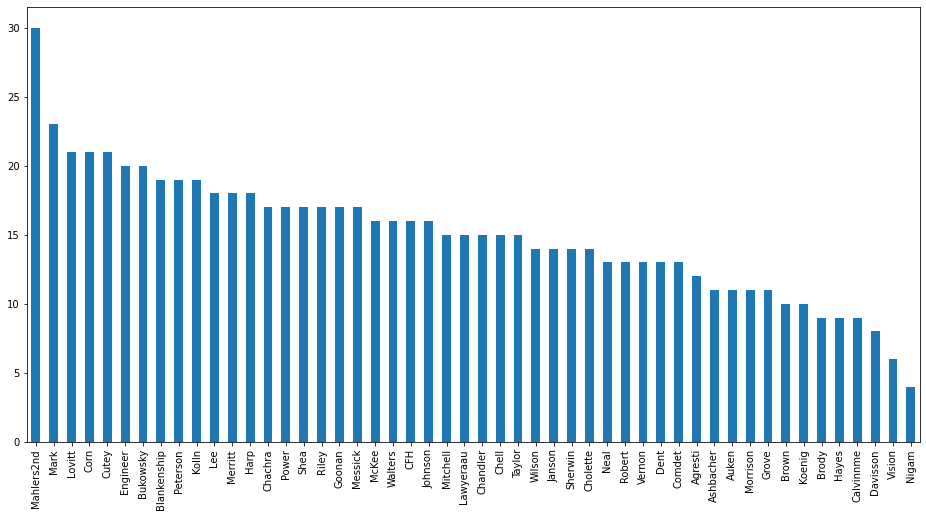

In [93]:
df_solution_test = pd.DataFrame(df_data_test['ID'])
df_solution_test['Class'] = [class_index[p] for p in y_prediction]
df_solution_test = df_solution_test.set_index('ID')

df_solution_test.to_csv('solution_test_nn.csv')

display(df_solution_test)


# Class distribution
fig = plt.figure(figsize=(16,8))
df_solution_test['Class'].value_counts().plot(kind='bar')
plt.show()

## VotingClassifier¶

#### SVC

In [53]:
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC

# SVC (TF-IDF)
c = OneVsRestClassifier(SVC(C=9.75, kernel='rbf', probability=True))
c.fit(X_tfidf, y)

# Predict
y_prediction_svc = c.predict_proba(X_test_tfidf)
y_prediction_svc

array([[1.22700544e-05, 1.83871601e-04, 7.30216406e-03, ...,
        6.58552736e-05, 3.79377350e-05, 3.01355075e-05],
       [3.01771024e-05, 3.18205443e-04, 8.58248498e-04, ...,
        2.61653207e-04, 2.00459522e-04, 7.06157847e-03],
       [6.71203206e-05, 1.40674432e-03, 1.07459275e-03, ...,
        2.44275431e-04, 1.68137236e-04, 4.17696232e-03],
       ...,
       [1.66431744e-03, 7.60264047e-04, 3.76949300e-03, ...,
        1.24807555e-04, 1.71515396e-03, 2.26585706e-03],
       [2.02023167e-02, 2.75908106e-04, 7.45770681e-01, ...,
        1.85814713e-03, 1.01799229e-02, 1.70826913e-04],
       [5.25433846e-03, 6.11026454e-04, 2.97593162e-03, ...,
        1.32511065e-05, 3.53072768e-04, 1.26105351e-04]])

In [54]:
np.sum(y_prediction_svc[0])

0.9999999999999998

#### Random Forest

In [29]:
from sklearn.ensemble import RandomForestClassifier

# RandomForest (TF-IDF)
c = OneVsRestClassifier(RandomForestClassifier(n_estimators=500, max_depth=10, criterion='entropy'))
c.fit(X_tfidf, y)

# Predict
y_prediction_rf = c.predict_proba(X_test_tfidf)
y_prediction_rf

array([[0.0095498 , 0.0095498 , 0.01500682, ..., 0.        , 0.00682128,
        0.00136426],
       [0.02131783, 0.00581395, 0.02131783, ..., 0.00968992, 0.00387597,
        0.01356589],
       [0.00290684, 0.01733786, 0.01733786, ..., 0.01155857, 0.01444822,
        0.0202275 ],
       ...,
       [0.00263817, 0.00527633, 0.03165799, ..., 0.        , 0.0079145 ,
        0.00527633],
       [0.05711541, 0.00316404, 0.08542914, ..., 0.01898425, 0.01898425,
        0.00632808],
       [0.0394921 , 0.00631723, 0.01737239, ..., 0.00473792, 0.00157931,
        0.01421377]])

In [30]:
np.sum(y_prediction_rf[0])

0.9999999999999996

#### MLP

In [31]:
def normalize_output(array_in):
    norm = np.linalg.norm(array_in, ord=1)
    return array_in/norm

y_prediction_nn = normalize_output(y_output[0].detach().numpy())
print(np.sum(y_prediction_nn))

0.99999994


In [98]:
y_prediction_vote = []


df_voting = pd.DataFrame()
for i in range(0, len(y_prediction_rf)):
    y_prediction_svc_v = y_prediction_svc[i]
    max_idx_svc = np.argmax(y_prediction_svc_v)
    max_pred_svc = y_prediction_svc_v[max_idx_svc]
    
    y_prediction_rf_v = y_prediction_rf[i]
    max_idx_rf = np.argmax(y_prediction_rf_v)
    max_pred_rf = y_prediction_rf_v[max_idx_rf]
    
    
    y_prediction_nn_v = normalize_output(y_output[i].detach().numpy())
    max_idx_nn = np.argmax(y_prediction_nn_v)
    max_pred_nn = y_prediction_nn_v[max_idx_nn]

    a = 1.0 # weight SVC
    b = 0.0 # weight RF
    c = 1.0 # weight NN
    
    y_prediction_vote_v = [y_prediction_svc_v[idx] * a + y_prediction_rf_v[idx] * b + y_prediction_nn_v[idx] * c for idx in range(0, len(y_prediction_rf_v))]
    
    max_idx_vote = np.argmax(y_prediction_vote_v)
    max_pred_vote = y_prediction_vote_v[max_idx_vote]
    
    y_prediction_vote.append(max_idx_vote)
    
    df_voting = df_voting.append({
        'svc_max_idx': max_idx_svc,
        'svc_max': max_pred_svc,
        'rf_max_idx': max_idx_rf,
        'rf_max': max_pred_rf,
        'nn_max_idx': max_idx_nn,
        'nn_max': max_pred_nn,
        'vote_max_idx': max_idx_vote,
        'vote_max': max_pred_vote
    }, ignore_index=True)
    
df_voting.to_csv('voting_test.csv')

display(df_voting[df_voting['nn_max_idx'] != df_voting['rf_max_idx']])

df_voting[df_voting['nn_max_idx'] != df_voting['rf_max_idx']].to_csv('voting_test_diff.csv')

,nn_max,nn_max_idx,rf_max,rf_max_idx,svc_max,svc_max_idx,vote_max,vote_max_idx
9,0.952351,27.0,0.078200,47.0,0.435220,27.0,1.387571,27.0
12,0.304616,34.0,0.066119,0.0,0.379854,3.0,0.412722,3.0
15,0.883773,44.0,0.058106,29.0,0.495009,42.0,0.958397,44.0
16,0.240137,0.0,0.039857,21.0,0.254991,4.0,0.376456,4.0
19,0.907796,46.0,0.062778,0.0,0.304144,46.0,1.211941,46.0
...,...,...,...,...,...,...,...,...
736,0.158773,16.0,0.070093,33.0,0.269460,24.0,0.290001,24.0
744,0.772241,14.0,0.062356,16.0,0.420014,16.0,0.948736,14.0
745,0.606828,42.0,0.062022,28.0,0.496044,42.0,1.102872,42.0
746,0.523986,1.0,0.067974,23.0,0.349634,34.0,0.709551,1.0


,Class
ID,
750,Blankenship
751,Hayes
752,Goonan
753,Dent
754,Engineer
...,...
1495,Corn
1496,Engineer
1497,Lawyeraau


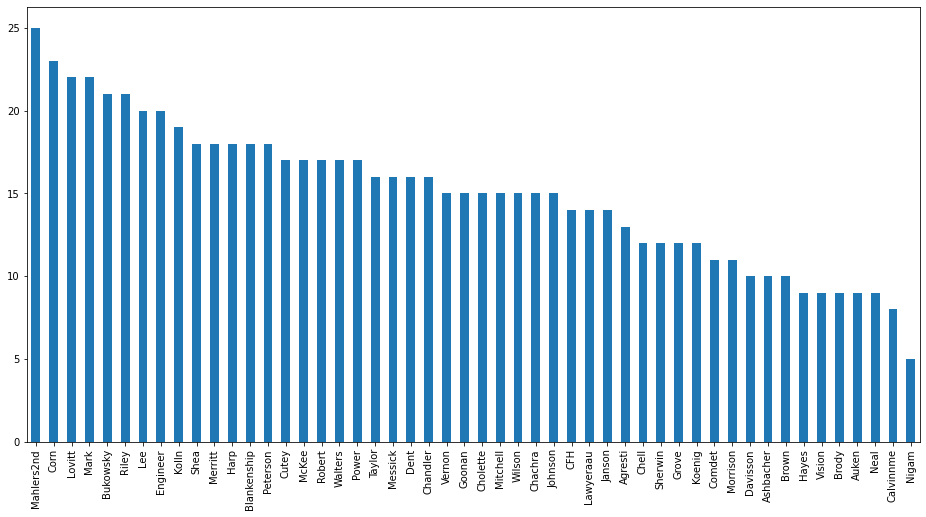

In [99]:
df_voting_solution_test = pd.DataFrame(df_data_test['ID'])
df_voting_solution_test['Class'] = [class_index[p] for p in y_prediction_vote]
df_voting_solution_test = df_voting_solution_test.set_index('ID')
df_voting_solution_test

df_voting_solution_test.to_csv('solution_test_vote.csv')

display(df_voting_solution_test)


# Class distribution
fig = plt.figure(figsize=(16,8))
df_voting_solution_test['Class'].value_counts().plot(kind='bar')
plt.show()